Expresiones sacadas de 
- Diapositivas de clase
- Cheat Sheet https://www.bogan.ca/orbits/kepler/orbteqtn.html
- Semi eje mayor https://phys.libretexts.org/Bookshelves/Astronomy__Cosmology/Celestial_Mechanics_(Tatum)/10%3A_Computation_of_an_Ephemeris/10.06%3A_Elements_of_a_Hyperbolic_Orbit
- Hiperbolica https://control.asu.edu/Classes/MAE462/462Lecture05.pdf

In [3]:
import numpy as np
from scipy.optimize import root_scalar
from astropy import units as u
from astropy.time import Time
from astropy.time import TimezoneInfo
import matplotlib.pyplot as plt

# Simbolos y constantes
"""
a = semieje mayor
e = excentricidad
omega = longitud del nodo ascendente
w = argumento del pericentro
i = inclinacion de la orbita
n = movimiento medio
lo = anomalia media en la epoca
tp = tiempo del perihelio
to = tiempo de la epoca
M = la suma de las masas de los cuerpos
GM = Parametro gravitacional del sol
radio_tierra = Radio terrestre medido en el ecuador. Wikipedia
"""

# Efemerides de la tierra
a_tierra = (1.495582533630905E+8*u.km).to('au')
ecc_tierra = 1.694863932474438E-02
omega_tierra = 1.498625963929686E+02*u.deg
w_tierra = 3.146587763491455E+02*u.deg
i_tierra = 4.164075603038432E-03*u.deg
n_tierra = 1.141204629731537E-05*u.deg/u.s
l0_tierra = 1.817846947871890E+02*u.deg
GM_sol = 132712440041.93938*u.km**3/u.s**2
GM_sol = GM_sol.to("au**3/day**2")
radio_tierra = 6378.1*u.km


#Transformacion de unidades
omega_tierra = omega_tierra.to('rad')
w_tierra = w_tierra.to('rad')
i_tierra = i_tierra.to('rad')
n_tierra = n_tierra.to('rad/s')
l0_tierra = l0_tierra.to('rad')


## Funciones de la Tierra
def Kepler_ellpitic(E, l, ecc):
    f = E - ecc*np.sin(E) - l
    fprime = 1 - ecc*np.cos(E)
    return f, fprime

def find_iota(t, t0, l0, n):
    return (l0 + n*(t-t0))

def find_f_elliptic(e, E):
    root_term = np.sqrt( (1+e)/(1-e) )
    right_side = root_term*np.tan(E/2)
    f = 2*np.arctan(right_side)
    return f

def find_r_elliptic(a, ecc, E):
    return a*(1 - ecc*np.cos(E))

def find_xyz (r, Om, phi, i):
    x = r*(np.cos(Om)*np.cos(phi) - np.cos(i)*np.sin(Om)*np.sin(phi))
    y = r*(np.sin(Om)*np.cos(phi) + np.cos(i)*np.cos(Om)*np.sin(phi))
    z = r*(np.sin(i)*np.sin(phi))
    return (x, y, z)

def find_norm(vector):
    num = np.sqrt(vector[0].value**2 + vector[1].value**2 + vector[2].value**2)
    return num


##____________________________________________________________________________________________________##
## Funciones del cometa
def find_velocidad():
    # Se usa el método del punto medio
    h = tiempos_cometa_inicial[1].utc- tiempos_cometa_inicial[0]
    velocidades_cometa_inicial = [0,0,0]
    for ii in range (3):
        velocidades_cometa_inicial[ii] = \
        (coor_cometa_inicial[2][ii]*u.au - coor_cometa_inicial[0][ii]*u.au) / (2*h)
    return velocidades_cometa_inicial


def choque(tiempos, xyz_t_tierra, xyz_t_cometa, radio_tierra, radio_cometa):
    tolerancia = 0
    gmt_minus_5 = TimezoneInfo(-5 * u.hour)
    suma_radios = radio_tierra + radio_cometa
    
    delta_posiciones = np.transpose(xyz_t_tierra - xyz_t_cometa)
    distancias = [np.linalg.norm(delta) for delta in delta_posiciones]
    
    for ii, delta in enumerate(distancias):
        if delta <= suma_radios + tolerancia:
            tiempo = tiempos[ii]
            tiempo = tiempo.to_datetime(timezone=gmt_minus_5)                
            print(f'***¡¡¡Choque inminente!!!*** \n')
            print(f'La Tierra y el cometa chocarán el día {tiempo} hora local GMT -5:00 \n')
            print(f'Coordenadas heliocéntricas de la Tierra en el choque:')
            print(f'x = {xyz_t_tierra[0][ii]}')
            print(f'y = {xyz_t_tierra[1][ii]}')
            print(f'z = {xyz_t_tierra[2][ii]}')
            break

    minima_distancia = u.au*min(distancias)
    index_minima_distancia = distancias.index(minima_distancia.value)
    tiempo = tiempos[index_minima_distancia]
    tiempo = tiempo.to_datetime(timezone=gmt_minus_5)    
    print(f'¡Qué mal, sobrevivimos!\n')
    print(f'Distancia de máximo acercamiento: {minima_distancia}\n')
    print(f'Distancia de máximo acercamiento: {minima_distancia.to("km")}\n')
    print(f'Ocurrió el día: {tiempo}\n')


##______________________________________________________________________________________##

## Parámetros temporales de la tierra
N_tiempos = (10*6 * 24*365)
#N_tiempos = (1*12)
t0 = Time('2023-07-09T00:00:00', scale='tdb', format = 'isot').utc
tf = Time('2023-12-09T00:00:00', scale='tdb', format = 'isot').utc
#tf = Time('2024-07-09T00:00:00', scale='tdb', format = 'isot').utc
tiempos_evolucion = np.linspace(t0, tf, N_tiempos)
delta_t = (tiempos_evolucion[1] - tiempos_evolucion[0]).to("hour")

## Calculo orbita Tierra
plot_tierra_data = np.zeros((3, N_tiempos))
plot_cometa_data = np.zeros((3, N_tiempos))

## Hallamos parámetros inicializadores
E_0_tierra = np.arccos((1 - 1.0166713776289134/a_tierra.value)/ecc_tierra)*u.rad
l0_tierra = E_0_tierra - ecc_tierra*np.sin(E_0_tierra)*u.rad
n_tierra = np.sqrt(GM_sol/a_tierra**3)*u.rad
t0 = tiempos_evolucion[0]


for ii, t in enumerate(tiempos_evolucion):
    ## 1. Hallar iota
    iota_tierra = find_iota(t, t0, l0_tierra, n_tierra)


    ## 2. Solucionar la Ec. de Kepler
    E_raiz_tierra = root_scalar(Kepler_ellpitic, args=(iota_tierra.value, ecc_tierra), \
                                fprime = True, x0 = 0, xtol = 1E-8).root*u.rad


    ## 3. Hallar f
    f_tierra = find_f_elliptic(ecc_tierra, E_raiz_tierra)
    #print(f_tierra)


    ## 4. Hallar phi
    phi_tierra = f_tierra + w_tierra


    ## 5. Hallar r
    r_tierra = find_r_elliptic(a_tierra, ecc_tierra, E_raiz_tierra)


    ## 6. Hallar x, y, z
    coor_tierra = find_xyz (r_tierra, omega_tierra, phi_tierra, i_tierra)
    for jj in range (3):
        plot_tierra_data[jj, ii] = coor_tierra[jj].value



##______________________________________________________________________________________##

## Parámetros temporales del cometa
tiempos_cometa_inicial = [
    Time('2023-07-09T10:00:00', scale='utc', format = 'isot'), Time('2023-07-09T12:00:00', scale='utc', format = 'isot'),
    Time('2023-07-09T14:00:00', scale='utc', format = 'isot'), Time('2023-08-03T11:00:00', scale='utc', format = 'isot'),
    Time('2023-08-15T08:00:00', scale='utc', format = 'isot'), Time('2023-08-21T09:00:00', scale='utc', format = 'isot')]

## Parámetros espaciales
coor_cometa_inicial = [
    [0.7059032210909959, -1.769547135717722,  0.0001947177390506007],
    [0.7064970232872655, -1.7682131326526134, 0.00019457094778662054],
    [0.7070906151926998, -1.7668786032741868, 0.0001944240986080829],
    [0.872092016693313,  -1.3428833384937209, 0.00014776843306531259],
    [0.9384794366420242, -1.1201770592759264, 0.0001232622403302589],
    [0.9676790988216054, -1.0012044164866674, 0.00011017070773121165]]


## Hallamos vector r del cometa
r_cometa_inicial = [np.linalg.norm(coor_cometa_inicial[ii]) for ii in range (6)]

## Hallamos Velocidad v del cometa
velocidades_cometa_inicial = find_velocidad()
velocidades_cometa_inicial_valor = []

for ii in range (3):
    velocidades_cometa_inicial_valor.append(velocidades_cometa_inicial[ii].value)

## Hallamos momento angular L
L_cometa =  np.cross(coor_cometa_inicial[1], velocidades_cometa_inicial_valor) #au**2/day
L_cometa_hat = L_cometa / np.linalg.norm(L_cometa)

## Hallamos la excentricidad e
ecc_cometa_vector = np.cross(velocidades_cometa_inicial_valor, L_cometa) / GM_sol.value - coor_cometa_inicial[1]/r_cometa_inicial[1]
ecc_cometa = np.linalg.norm(ecc_cometa_vector)
ecc_cometa_hat = ecc_cometa_vector/ecc_cometa

## Hallamos el semilactus rectum P
P_cometa = ((np.linalg.norm(L_cometa)*u.au**2/u.day)**2) / GM_sol

## Hallamos Perihelio
perihelio_cometa = P_cometa / (1 + ecc_cometa)

## Hallamos el semieje mayor
aux_top = GM_sol*r_cometa_inicial[1]*u.au
aux_bot = 2*GM_sol - r_cometa_inicial[1]*u.au*np.linalg.norm(velocidades_cometa_inicial_valor)**2*(u.au/u.day)**2
a_cometa = aux_top / aux_bot

## Hallamos la energia especifica del sistema
energia_e_cometa = -GM_sol  / (2*a_cometa) ##energia > 0 orbita hiperbolica
energia_e_tierra = -GM_sol / (2*a_tierra) ## energia < 0 orbita eliptica


i_cometa = np.arccos(np.dot(L_cometa_hat, [0,0,1]))*u.rad
omega_cometa = np.arcsin(np.dot(L_cometa_hat, [1,0,0])/np.sin(i_cometa))
if omega_cometa < 0:
    omega_cometa = 2*np.pi*u.rad - omega_cometa

w_cometa = np.arcsin(np.dot(ecc_cometa_hat, [0,0,1])/np.sin(i_cometa))
if ecc_cometa_vector [2] < 0 :
    w_cometa = 2*np.pi *u.rad - w_cometa

periodo_cometa = np.sqrt((4 * np.pi**2 * a_cometa**3) / (GM_sol))


## Cálculo orbita cometa ##
## Hallamos parámetros inicializadores
E_0_cometa = -np.arccos((1 - r_cometa_inicial[1]/a_cometa.value)/ecc_cometa)*u.rad
l0_cometa = E_0_cometa - ecc_cometa*np.sin(E_0_cometa)*u.rad
n_cometa = np.sqrt(GM_sol/a_cometa**3)*u.rad
t0 = tiempos_cometa_inicial[1]


for ii, t in enumerate(tiempos_evolucion):
    ## 1. Hallar iota
    iota_cometa = find_iota(t, t0, l0_cometa, n_cometa)


    ## 2. Solucionar la Ec. de Kepler
    E_raiz_cometa = root_scalar(Kepler_ellpitic, args=(iota_cometa.value, ecc_cometa), fprime = True, x0 = 0, xtol = 1E-8).root*u.rad


    ## 3. Hallar f
    f_cometa = find_f_elliptic(ecc_cometa, E_raiz_cometa)
    #print(f_tierra)


    ## 4. Hallar phi
    phi_cometa = f_cometa + w_cometa


    ## 5. Hallar r
    r_cometa = find_r_elliptic(a_cometa, ecc_cometa, E_raiz_cometa)


    ## 6. Hallar x, y, z
    coor_cometa = find_xyz (r_cometa, omega_cometa, phi_cometa, -i_cometa) 
    for jj in range (3):
        plot_cometa_data[jj, ii] = coor_cometa[jj].value

        
        

# Compracion efemerides  cometa vs tierra
print('Comparacion efemerides cometa vs tierra')
print('Energias =', energia_e_cometa, energia_e_tierra)
print('semieje mayor  a =', a_cometa, a_tierra)
print('excentricidad e = ', ecc_cometa, ecc_tierra)
print('inclinacion i =', i_cometa, i_tierra)
print('nodo ascentente \u03A9 = ', omega_cometa, omega_tierra)
print('argumento del pericentro w =', w_cometa, w_tierra)
print(f'Periodo del cometa: {periodo_cometa.to("yr"):.3f}\n\n\n\n')


                

radio_cometa = 100*u.km
choque(tiempos_evolucion, plot_tierra_data, plot_cometa_data, radio_tierra.to("au").value, radio_cometa.to("au").value)
print(f'Paso de tiempo cada {delta_t}')
print(f'Paso de tiempo cada {delta_t.to("minute")}')

Comparacion efemerides cometa vs tierra
Energias = -1.847899888227041e-06 AU2 / d2 -0.0001479952970772798 AU2 / d2
semieje mayor  a = 80.06716439858185 AU 0.9997351744598761 AU
excentricidad e =  0.987862521648173 0.01694863932474438
inclinacion i = 0.00011003817552377976 rad 7.267682957498903e-05 rad
nodo ascentente Ω =  6.283185307179704 rad 2.6155957326446804 rad
argumento del pericentro w = 6.648580560880178 rad 5.491831667589052 rad
Periodo del cometa: 716.457 yr




¡Qué mal, sobrevivimos!

Distancia de máximo acercamiento: 0.022363068380243052 AU

Distancia de máximo acercamiento: 3345467.4120028582 km

Ocurrió el día: 2023-10-23 15:42:46.027040-05:00

Paso de tiempo cada 0.006986314662297488 h
Paso de tiempo cada 0.4191788797378493 min


Text(0.5, 0, 'Z (U.A.)')

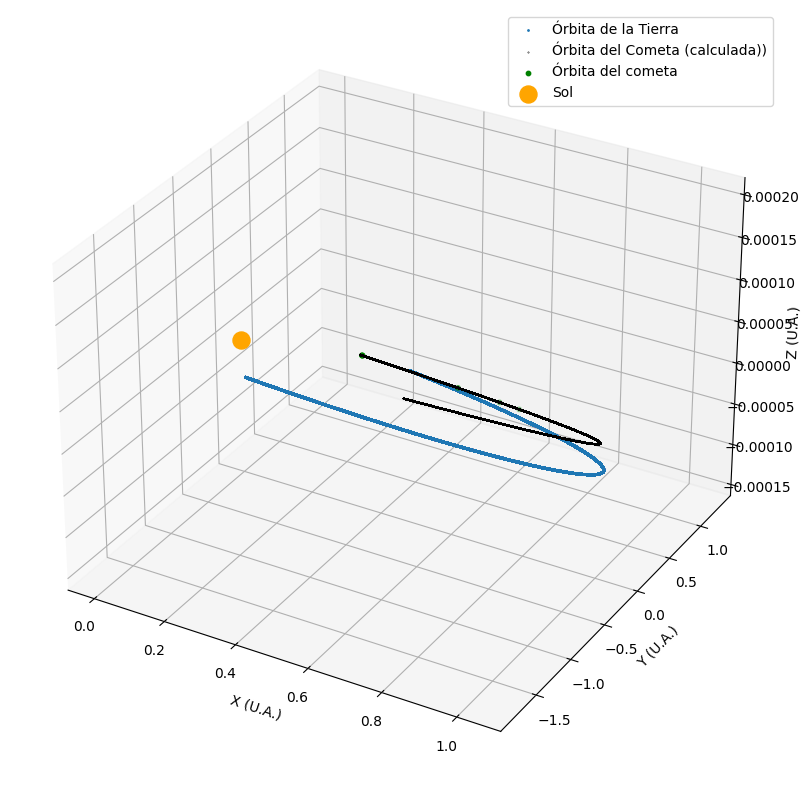

In [4]:
coor_cometa_inicial = np.transpose(coor_cometa_inicial)
## Plot de las ótbita
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
ax.scatter(plot_tierra_data[0], plot_tierra_data[1], plot_tierra_data[2], label='Órbita de la Tierra', s=1)
ax.scatter(plot_cometa_data[0], plot_cometa_data[1], plot_cometa_data[2], label='Órbita del Cometa (calculada))', s=0.1, color="black")

ax.scatter(coor_cometa_inicial[0], coor_cometa_inicial[1], coor_cometa_inicial[2], label='Órbita del cometa', s=10, color="green")
ax.scatter(0, 0, 0, s=150, label='Sol', color="orange")

ax.legend()
#ax.set_xlim(-1, 1)
#ax.set_ylim(-1, 1)
#ax.set_zlim(-1, 1)
ax.set_xlabel('X (U.A.)')
ax.set_ylabel('Y (U.A.)')
ax.set_zlabel('Z (U.A.)')